In [1]:
import sys
import os
sys.path.append('../src')


In [2]:
import numpy as np
import pandas as pd
import pcalg
import networkx as nx
from conditional_independence import partial_correlation_suffstat, partial_correlation_test
from mcmc.mcmc import PartitionMCMC, StructureMCMC
from mcmc.data import SyntheticDataset
from mcmc.proposals import PartitionProposal
from mcmc.scores import BGeScore, BDeuScore

In [3]:
np.random.seed(32205)
data = np.zeros((200, 3))

data[:,0] = np.random.choice([1,2], size=200)
data[:,1] = np.random.choice([3,4], size=200)
data[:,2] = np.logical_and(data[:,0]==1, data[:,1]==3)
data = pd.DataFrame(data, columns=['A', 'B', 'C'])
gt = np.array([[0,0,1],[0,0,1],[0,0,0]])

In [4]:
data

,A,B,C
0,1.0,3.0,1.0
1,1.0,3.0,1.0
2,1.0,3.0,1.0
3,2.0,4.0,0.0
4,2.0,3.0,0.0
...,...,...,...
195,1.0,4.0,0.0
196,2.0,4.0,0.0
197,1.0,4.0,0.0
198,2.0,4.0,0.0


In [10]:
# M = StructureMCMC(max_iter=30000, data=data, score_object='bde', pc_init=False)
M = PartitionMCMC(max_iter=30000, data=data, score_object='bde', pc_init=False)

In [11]:
mcmc_results, acceptance = M.run()
graphs = M.get_mcmc_res_graphs(mcmc_results)
print('Acceptance_ratio:', acceptance)

Acceptance_ratio: 0.4077


In [12]:
from mcmc.utils.graph_utils import generate_key_from_adj_matrix

BURN_IN = 0.0

graphs = M.get_mcmc_res_graphs(mcmc_results)

key = generate_key_from_adj_matrix(gt)
keys, counts = np.unique([generate_key_from_adj_matrix(g) for g in graphs[int(BURN_IN*len(graphs)):]], return_counts=True)
print(key in keys)
print(graphs)

True
[array([[0., 0., 0.],
       [0., 0., 0.],
       [1., 1., 0.]]), array([[0., 0., 0.],
       [0., 0., 0.],
       [1., 1., 0.]]), array([[0., 0., 0.],
       [0., 0., 0.],
       [1., 1., 0.]]), array([[0., 0., 0.],
       [0., 0., 0.],
       [1., 1., 0.]]), array([[0., 1., 0.],
       [0., 0., 0.],
       [1., 1., 0.]]), array([[0., 0., 0.],
       [1., 0., 0.],
       [1., 1., 0.]]), array([[0., 0., 0.],
       [1., 0., 1.],
       [1., 0., 0.]]), array([[0., 0., 0.],
       [1., 0., 0.],
       [1., 1., 0.]]), array([[0., 0., 0.],
       [1., 0., 0.],
       [1., 1., 0.]]), array([[0., 0., 0.],
       [1., 0., 1.],
       [1., 0., 0.]]), array([[0., 0., 0.],
       [1., 0., 1.],
       [1., 0., 0.]]), array([[0., 0., 0.],
       [1., 0., 0.],
       [1., 1., 0.]]), array([[0., 0., 0.],
       [1., 0., 1.],
       [1., 0., 0.]]), array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 0.]]), array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 0.]]), array([[0., 0., 1.]

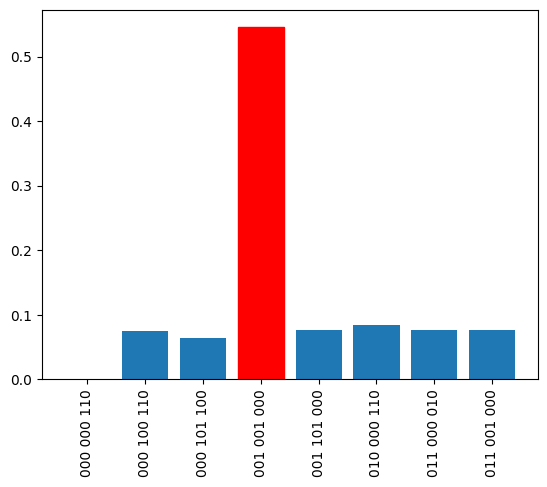

In [13]:
from matplotlib import pyplot as plt

bars = plt.bar(range(len(keys)), counts/sum(counts))
plt.xticks(range(len(keys)), keys, rotation=90);
bars[np.where(keys==key)[0][0]].set_color('red')

-298.18129224726647


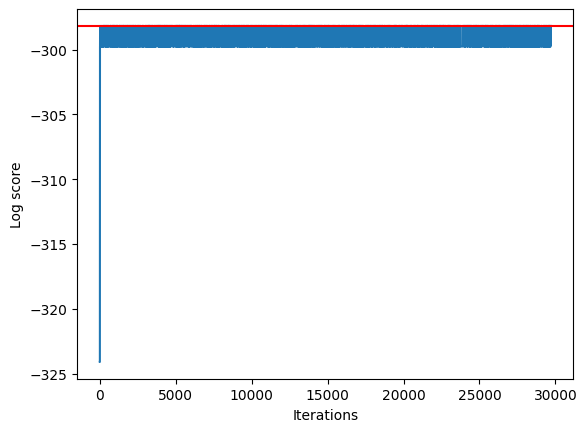

In [14]:
from mcmc.utils.partition_utils import convert_partition_to_party_permy_posy
from mcmc.utils.score_utils import partition_score
from mcmc.utils.partition_utils import convert_partition_to_party_permy_posy, build_partition

def get_mcmc_scores(results):
        mcmc_graph_lst = []
        for i in results:
            mcmc_graph_lst.append( results[i]['score_P_curr'] )
        return mcmc_graph_lst
scores = get_mcmc_scores(mcmc_results)

true_partition = build_partition(incidence=gt, node_labels=list(data.columns))
party_curr, permy_curr, posy_curr = convert_partition_to_party_permy_posy(true_partition)
true_score = partition_score(M.node_labels, M.node_labels, M.parent_table, M.score_table, permy_curr, party_curr, posy_curr )
true_score = sum(true_score['total_scores'].values())
plt.plot(range(len(scores)), scores)
plt.axhline(true_score, color='r')
plt.xlabel('Iterations')
plt.ylabel('Log score')
print(true_score)